## Imports

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # can be used to make histogram of the image
import cv2

## Data Reading

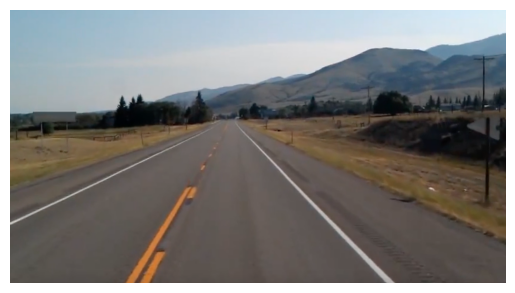

In [136]:
img_cv2 = cv2.imread(r'images\\Road_img2.png')
img_plt = plt.imread(r'images\\Road_img2.png')
plt.imshow(img_plt)
plt.axis('off')
plt.show()

In [137]:
img_cv2.shape

(704, 1279, 3)

## Grayscale Coversion

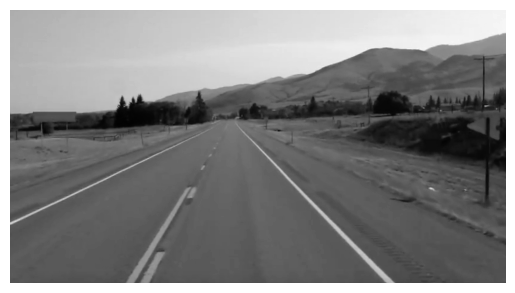

In [138]:
gray_img = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()


## Median Blur

In [139]:
median_img = cv2.medianBlur(gray_img, 5)  

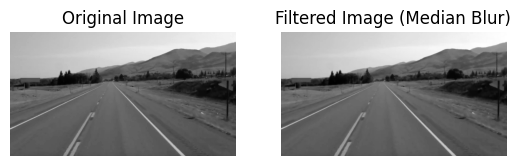

In [140]:
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
#image after median blur
plt.subplot(1, 2, 2)
plt.imshow(median_img, cmap='gray')
plt.title("Filtered Image (Median Blur)")
plt.axis('off')

plt.show()

## Canny

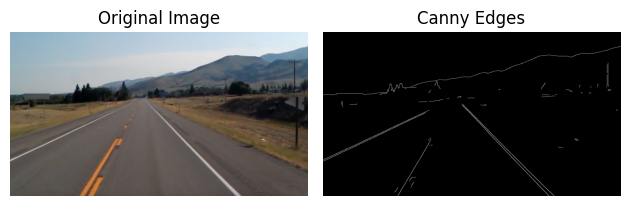

In [141]:
edges = cv2.Canny(median_img, threshold1=120, threshold2=185)

# Display the results
# cv2.imshow("Original Image", img_cv2)
# cv2.imshow("Canny Edges", edges)

plt.subplot(1, 2, 1)
plt.imshow(img_plt)  # Show original image in RGB
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")  # Show Canny edges in grayscale
plt.title("Canny Edges")
plt.axis("off")

plt.tight_layout()
plt.show()


## ROI

In [142]:
height, width = edges.shape
mask = np.zeros_like(edges)

In [143]:
polygon = np.array([[
    (0, height),  # Bottom left
    (0, height//2),  # Mid left
    (width*0.75, height//2.2),  # Mid right
    (width*0.75, height)  # Bottom right
]], dtype=np.int32)

In [144]:
cv2.fillPoly(mask, polygon, 255)
masked_edges = cv2.bitwise_and(edges, mask)

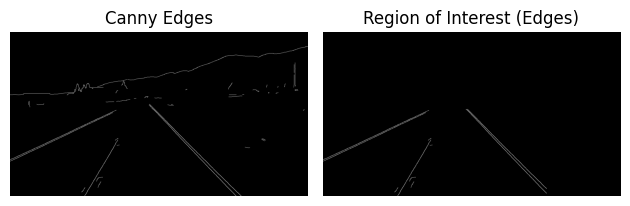

In [145]:
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap="gray")  # Show Canny edges in grayscale
plt.title("Canny Edges")
plt.axis("off")


plt.subplot(1, 2, 2)
plt.imshow(masked_edges, cmap='gray')
plt.title("Region of Interest (Edges)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Lane Detection Output

In [146]:
rho = 1  # Distance resolution in pixels
theta = np.pi/180  # Angle resolution in radians
threshold = 50  # Minimum votes in accumulator
threshold2 = 150
min_line_length = 100  # Minimum line length to consider
max_line_gap = 50  # Maximum gap between line segments

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, minLineLength=min_line_length, maxLineGap=max_line_gap)

lane_image = img_cv2.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lane_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

In [ ]:
def hough_lines_p(edge_image, rho, theta, threshold, min_line_length, max_line_gap):
    height, width = edge_image.shape
    theta_values = np.arange(0, np.pi, theta)
    cos_theta = np.cos(theta_values)
    sin_theta = np.sin(theta_values)
    max_rho = int(np.hypot(height, width) / rho)  # Scale rho values properly
    accumulator = np.zeros((2 * max_rho, len(theta_values)), dtype=np.int32)
    edge_points = np.argwhere(edge_image)
    
    for y, x in edge_points:
        for t_idx, (cos_t, sin_t) in enumerate(zip(cos_theta, sin_theta)):
            rho_val = int((x * cos_t + y * sin_t) / rho) + max_rho  # Use rho step size
            accumulator[rho_val, t_idx] += 1
    
    line_segments = []
    for r_idx in range(accumulator.shape[0]):
        for t_idx in range(accumulator.shape[1]):
            if accumulator[r_idx, t_idx] >= threshold:
                rho_val = (r_idx - max_rho) * rho  
                theta_val = theta_values[t_idx]
                a = np.cos(theta_val)
                b = np.sin(theta_val)
                x0 = a * rho_val
                y0 = b * rho_val
                x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
                x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
                line_segments.append(((x1, y1), (x2, y2)))
    
    filtered_segments = []
    for (x1, y1), (x2, y2) in line_segments:
        if np.hypot(x2 - x1, y2 - y1) >= min_line_length:
            filtered_segments.append(((x1, y1), (x2, y2)))
    
    final_segments = []
    for i, ((x1, y1), (x2, y2)) in enumerate(filtered_segments):
        is_strongest = True
        for j, ((x3, y3), (x4, y4)) in enumerate(filtered_segments):
            if i != j:
                if abs(x1 - x3) < max_line_gap and abs(y1 - y3) < max_line_gap and abs(x2 - x4) < max_line_gap and abs(y2 - y4) < max_line_gap:
                    if np.hypot(x2 - x1, y2 - y1) < np.hypot(x4 - x3, y4 - y3):
                        is_strongest = False
                        break
        if is_strongest:
            final_segments.append(((x1, y1), (x2, y2)))
    
    return final_segments

In [148]:
lines = hough_lines_p(masked_edges, rho, theta, threshold2, min_line_length=min_line_length, max_line_gap=max_line_gap)

lane_image2 = img_cv2.copy()
if lines is not None:
    for (x1, y1), (x2, y2) in lines:
        cv2.line(lane_image2, (x1, y1), (x2, y2), (0, 255, 0), 5)


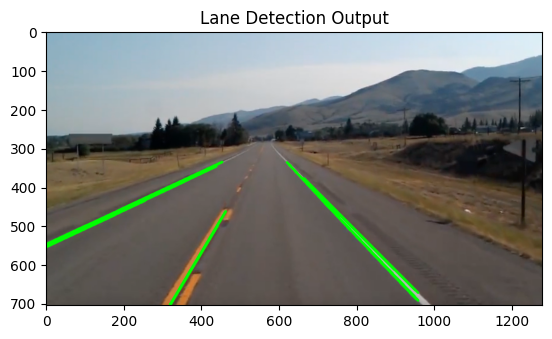

In [149]:
plt.imshow(cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB))
plt.title("Lane Detection Output")

plt.show()

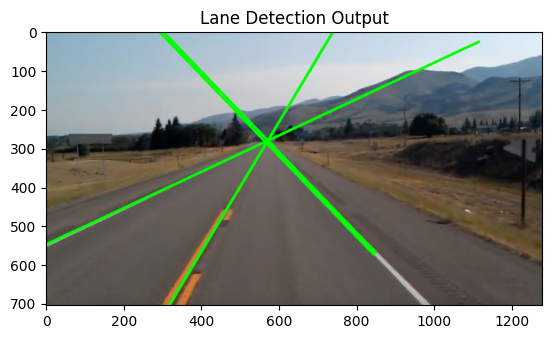

In [150]:
plt.imshow(cv2.cvtColor(lane_image2, cv2.COLOR_BGR2RGB))
plt.title("Lane Detection Output")

plt.show()

## Hough Space

In [151]:
height, width = edges.shape
max_rho = int(np.hypot(width, height))  # Maximum possible rho
rhos = np.arange(-max_rho, max_rho, 1)  # Range of possible rhos
thetas = np.deg2rad(np.arange(0, 181))  # Theta from 0 to 179 degrees

accumulator = np.zeros((len(rhos), len(thetas)))  # Initialize accumulator

    # Get all edge pixel coordinates
y_idxs, x_idxs = np.nonzero(masked_edges)

for i in range(len(x_idxs)):
    x = x_idxs[i]
    y = y_idxs[i]
    for t_idx, theta in enumerate(thetas):
        rho_value = int(x * np.cos(theta) + y * np.sin(theta))
        rho_idx = np.argwhere(rhos == rho_value)[0][0]  # Adjust for negative indexing
        accumulator[rho_idx, t_idx] += 1  # Voting process

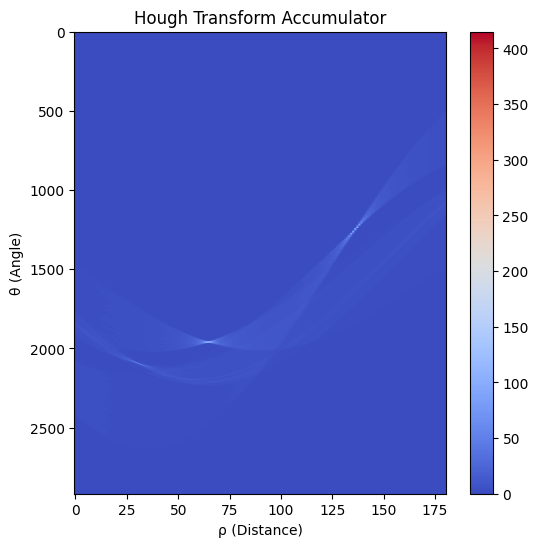

In [152]:
plt.figure(figsize=(6, 6))
plt.imshow(accumulator, cmap='coolwarm', aspect='auto')
plt.title("Hough Transform Accumulator")
plt.xlabel("ρ (Distance)")
plt.ylabel("θ (Angle)")
plt.colorbar()
plt.show()